#   Проект: "Обнаружение каверов музыкальных треков"

## Задачи проекта

Необходимо разработать решения, которые:

- может классифицировать треки по признаку кавер-некавер;
- связывать (группировать) каверы и исходный трек;
- находит исходный трек в цепочке каверов.

Для решения этой задачи используем любые открытые источники данных и собираем необходимую информацию, соблюдая правила использования сервисов, которые эту информацию предоставляют.

### Исходные данные

#### Таблица с разметками каверов

Файл covers.json содержит разметку каверов, сделанную редакторами сервиса:

- track_id - уникальный идентификатор трека;
- track_remake_type - метка, присвоенная редакторами. Может принимать значения ORIGINAL и COVER;
- original_track_id - уникальный идентификатор исходного трека.


#### Таблица с метаинформацией треков

- track_id - уникальный идентификатор трека;
- dttm - первая дата появления информации о треке;
- title - название трека;
- language - язык исполнения;
- isrc - международный уникальный идентификатор трека;
- genres - жанры;
- duration - длительность трека;

#### Таблица с текстами песен

- track_id - уникальный идентификатор трека;
- lyricId - уникальный идентификатор текста;
- text - текст трека.

## 1. Загрузка и анализ данных 

In [1]:
!pip install -U sentence-transformers

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os

from sentence_transformers import SentenceTransformer
from scipy import spatial
from scipy.spatial import cKDTree
from typing import Tuple

from sklearn.metrics.pairwise import cosine_similarity

In [2]:
try:
    covers = pd.read_json('C:\\Users\\Aleksey\\Downloads\\covers.json', lines=True)
    lyrics = pd.read_json('C:\\Users\\Aleksey\\Downloads\\lyrics.json', lines=True)
    meta = pd.read_json('C:\\Users\\Aleksey\\Downloads\\meta.json', lines=True)
except:
    raise Exception('Check the files')

In [3]:
def get_dataset_info(df: pd.DataFrame) -> None:
    display(df.head())
    print('\n')
    print(df.info())
    print('\n')
    
    try:
        print(df.isna().sum())
        print(df.duplicated().sum())
    except:
        print('Нечитаемый формат данных')
    print('\n')
    print('it`s over')

In [4]:
get_dataset_info(lyrics)

,lyricId,text,track_id
0,a951f9504e89759e9d23039b7b17ec14,"Живу сейчас обломами, обломками не той любви\n...",1c4b1230f937e4c548ff732523214dcd
1,0c749bc3f01eb8e6cf986fa14ccfc585,Tell me your fable\nA fable\nTell me your fabl...,0faea89b0d7d6235b5b74def72511bd8
2,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...,9c6dc41d5ccd9968d07f055da5d8f741
3,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...,bfd04a73e9cffdf0e282c92219a86ea1
4,7624653ca8522ba93470843c74961b7d,"You showed him all the best of you,\nBut I'm a...",8d70930d09cd239c948408d1317d8659




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11414 entries, 0 to 11413
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lyricId   11414 non-null  object
 1   text      11414 non-null  object
 2   track_id  11414 non-null  object
dtypes: object(3)
memory usage: 267.6+ KB
None


lyricId     0
text        0
track_id    0
dtype: int64
0


it`s over


В наличии всего 11,4 тыс. текстов треков из 71,5 тыс. треков.

In [5]:
get_dataset_info(meta)

,track_id,dttm,title,language,isrc,genres,duration
0,c3b9d6a354ca008aa4518329aaa21380,1.639688e+12,Happy New Year,EN,RUB422103970,[DANCE],161120.0
1,c57e3d13bbbf5322584a7e92e6f1f7ff,1.637762e+12,Bad Habits,EN,QZN882178276,[ELECTRONICS],362260.0
2,955f2aafe8717908c140bf122ba4172d,1.637768e+12,Por Esa Loca Vanidad,None,QZNJZ2122549,"[FOLK, LATINFOLK]",260000.0
3,fae5a077c9956045955dde02143bd8ff,1.637768e+12,Mil Lagrimas,None,QZNJZ2166033,"[FOLK, LATINFOLK]",190000.0
4,6bede082154d34fc18d9a6744bc95bf5,1.637768e+12,Sexo Humo y Alcohol,None,QZNJZ2122551,"[FOLK, LATINFOLK]",203000.0




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71769 entries, 0 to 71768
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   track_id  71768 non-null  object 
 1   dttm      71768 non-null  float64
 2   title     71768 non-null  object 
 3   language  21969 non-null  object 
 4   isrc      71455 non-null  object 
 5   genres    71768 non-null  object 
 6   duration  71768 non-null  float64
dtypes: float64(2), object(5)
memory usage: 3.8+ MB
None


track_id        1
dttm            1
title           1
language    49800
isrc          314
genres          1
duration        1
dtype: int64
Нечитаемый формат данных


it`s over


В meta около 50 тыс. пропусков в language и 313 пропусков в isrc.

In [5]:
get_dataset_info(covers)

,original_track_id,track_id,track_remake_type
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL
1,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,ORIGINAL
2,cd89fef7ffdd490db800357f47722b20,cd89fef7ffdd490db800357f47722b20,ORIGINAL
3,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL
4,None,d6288499d0083cc34e60a077b7c4b3e1,COVER




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  4821 non-null   object
 1   track_id           71597 non-null  object
 2   track_remake_type  71597 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB
None


original_track_id    66776
track_id                 0
track_remake_type        0
dtype: int64
0


it`s over


original_track_id известно лишь у 4,8 тыс. треков.

Text(0.5, 1.0, 'Распределение "track_remake_type"')

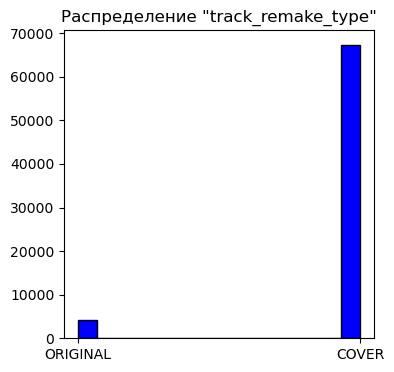

In [6]:
plt.figure(figsize=(4,4))
plt.hist(covers['track_remake_type'], color = 'blue', edgecolor = 'black',
         bins = 15)
plt.title('Распределение "track_remake_type"')


Посмотрим на количество каверов, размеченных заказчиком, для случайной трека по столбцу  'original_track_id'

In [7]:
covers.loc[covers['original_track_id'] == 'f3e5e9db509f9b6f6d93b9c38e4e1324']

,original_track_id,track_id,track_remake_type
211,f3e5e9db509f9b6f6d93b9c38e4e1324,f3e5e9db509f9b6f6d93b9c38e4e1324,ORIGINAL
243,f3e5e9db509f9b6f6d93b9c38e4e1324,9e20fd52b21566494b8d6586a39033c9,COVER
558,f3e5e9db509f9b6f6d93b9c38e4e1324,d71bd79936e69ffeb21ef6dd62e55b2e,COVER
2952,f3e5e9db509f9b6f6d93b9c38e4e1324,1dca7297005a6f9700e9eb43dd47a5e3,COVER
3907,f3e5e9db509f9b6f6d93b9c38e4e1324,214c5086fd618bc642260433c867f9c7,COVER
4385,f3e5e9db509f9b6f6d93b9c38e4e1324,28efa5567f2b3c090f311a3cb8805082,COVER
5828,f3e5e9db509f9b6f6d93b9c38e4e1324,18ad5f6948ce88882bf3791c22a3a53f,COVER
6676,f3e5e9db509f9b6f6d93b9c38e4e1324,ed541e2712a89d14b36170d912ef4698,COVER
7048,f3e5e9db509f9b6f6d93b9c38e4e1324,82aa19859b0f781fceca8b59de6b78ff,COVER
7053,f3e5e9db509f9b6f6d93b9c38e4e1324,04f227ff6ad073b4ac805d753d604337,COVER


К треку  c "track_id" = "f3e5e9db509f9b6f6d93b9c38e4e1324"  отмечены 37 каверов.

#### Выводы:
1. Данные разделены на 3 таблицы: необходимо таблицы объединить
1. В данных есть пропуски: необходимо обработать пропуски 
2. В данных отсуствует много текстов псесен: необходимо спарсить тексты треков из открытых источников

## 2. Предобработка данных

### 2.1 Объединение таблиц:

In [8]:
data = covers.merge(lyrics, how='outer', on='track_id')
data = data.merge(meta, how='outer', on='track_id')
data.head()

,original_track_id,track_id,track_remake_type,lyricId,text,dttm,title,language,isrc,genres,duration
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL,260f21d9f48e8de874a6e844159ddf28,Left a good job in the city\nWorkin' for the m...,1.257973e+12,Proud Mary,EN,USFI86900049,"[ROCK, ALLROCK]",187220.0
1,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL,f3331cf99637ee24559242d13d8cf259,Left a good job in the city\nWorkin' for the m...,1.257973e+12,Proud Mary,EN,USFI86900049,"[ROCK, ALLROCK]",187220.0
2,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,ORIGINAL,2498827bd11eca5846270487e4960080,Some folks are born made to wave the flag\nOoh...,1.257973e+12,Fortunate Son,EN,USFI86900065,"[ROCK, ALLROCK]",137780.0
3,cd89fef7ffdd490db800357f47722b20,cd89fef7ffdd490db800357f47722b20,ORIGINAL,5237001311d4062bf2b80de30652bf58,"Uno por pobre y feo, hombre\nPero antoja'o, ay...",1.253563e+12,La Camisa Negra,ES,USUL10400965,"[POP, FOLK, LATINFOLK]",216840.0
4,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL,e5b1b57090b728e8d98d2b4d9b781bf4,"Yeah!... yeah!... remember the time, baby... y...",1.258405e+12,The Way I Are,EN,USUM70722806,"[FOREIGNRAP, RAP]",179660.0


### 2.2 Парсинг данных

Для заполнения пропусков в "Text" и добавления данных с именами исполнителей спарсим данные с помощью библиотеки lyricsgenius из ресурса Genius (код выполнялся в отдельном файле и занял по времени двое суток, здесь запускаться не будет).
Ниже код:

```
import time
import pandas as pd
import lyricsgenius
import csv
from requests.exceptions import ReadTimeout

data = pd.read_csv('all_table.csv', sep='\t')
missing_songs = data.loc[data['text'].isna(), 'title'].unique().tolist()
token = 'here was token'
genius = lyricsgenius.Genius(token, skip_non_songs=True, excluded_terms=["(Remix)", "(Live)"],
                             remove_section_headers=True, timeout=40)

count = 0


def get_lyrics(songs: list) -> None:
    """
    Функция принимает список отсутствующих песен
    и по названию ищет текст в genius и добавляет в scv-файл
    :param songs: список песен
    :return: None
    """
    global count
    for song in songs:
        response = genius.search_song(str(song))
        time.sleep(1)

        count += 1
        print(count)

        with open('result.csv', mode='a', newline='', encoding="utf-8") as csvfile:
            textwriter = csv.writer(csvfile, delimiter='\t')
            if response:
                textwriter.writerow([count] + [song] + [response.artist] + [response.lyrics])
            else:
                textwriter.writerow([count] + [song] + [None] + [None])


if __name__ == '__main__':
    try:
        get_lyrics(missing_songs[count:])
    except ReadTimeout:
        get_lyrics(missing_songs[count - 1:])
```

Загрузим датасет с заполненными значениями в 'text' и именами исполнителей:

In [9]:
result = pd.read_csv('C:\\Users\\Aleksey\\Downloads\\result.csv', sep='\t')
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40131 entries, 0 to 40130
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   count   40131 non-null  int64 
 1   song    40129 non-null  object
 2   artist  37253 non-null  object
 3   text    37253 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [10]:
result.head()

,count,song,artist,text
0,1,Extraball,Yuksek,3 ContributorsExtraball LyricsNow I try to wal...
1,2,Bend,Drake,317 ContributorsTranslationsTürkçeEspañolPortu...
2,3,Live And Let Die,NaN,NaN
3,4,Have You Ever Seen The Rain,Creedence Clearwater Revival,62 ContributorsTranslationsEnglishHave You Eve...
4,5,She's Always A Woman,Billy Joel,33 ContributorsShe’s Always a Woman Lyrics\nSh...


Переименуем столбец song в title для объединения:

In [11]:
new_data = result.rename(columns={'song': 'title'})
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40131 entries, 0 to 40130
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   count   40131 non-null  int64 
 1   title   40129 non-null  object
 2   artist  37253 non-null  object
 3   text    37253 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


Объединим полученные данные с объединенной таблицей:

In [12]:
new_data = data.merge(new_data, how='outer', on='title')
new_data.head()

,original_track_id,track_id,track_remake_type,lyricId,text_x,dttm,title,language,isrc,genres,duration,count,artist,text_y
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL,260f21d9f48e8de874a6e844159ddf28,Left a good job in the city\nWorkin' for the m...,1.257973e+12,Proud Mary,EN,USFI86900049,"[ROCK, ALLROCK]",187220.0,2101.0,Creedence Clearwater Revival,39 ContributorsProud Mary Lyrics\nLeft a good ...
1,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL,f3331cf99637ee24559242d13d8cf259,Left a good job in the city\nWorkin' for the m...,1.257973e+12,Proud Mary,EN,USFI86900049,"[ROCK, ALLROCK]",187220.0,2101.0,Creedence Clearwater Revival,39 ContributorsProud Mary Lyrics\nLeft a good ...
2,eeb69a3cb92300456b6a5f4162093851,14cd5aac84c43bf6830c8276c05ee2f8,COVER,dee9f62b6793743f535dc38c3dbd9424,Left a good job down in the city\nWorkin' for ...,1.264972e+12,Proud Mary,EN,FRZ040600166,"[ROCK, ALLROCK]",395460.0,2101.0,Creedence Clearwater Revival,39 ContributorsProud Mary Lyrics\nLeft a good ...
3,eeb69a3cb92300456b6a5f4162093851,c99604698f81b2454389e8e3b6d3520b,COVER,d31d606bc0221f04551e2b04737bd24f,"You know, every now and then I think you might...",1.397678e+12,Proud Mary,EN,GBAYE9300862,"[POP, RNB]",327390.0,2101.0,Creedence Clearwater Revival,39 ContributorsProud Mary Lyrics\nLeft a good ...
4,eeb69a3cb92300456b6a5f4162093851,61a9281b78f3b0e06529e50183123233,COVER,NaN,NaN,1.401307e+12,Proud Mary,EN,ITS041000080,[POP],199780.0,2101.0,Creedence Clearwater Revival,39 ContributorsProud Mary Lyrics\nLeft a good ...


In [13]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72913 entries, 0 to 72912
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_track_id  5378 non-null   object 
 1   track_id           72911 non-null  object 
 2   track_remake_type  72573 non-null  object 
 3   lyricId            11416 non-null  object 
 4   text_x             11416 non-null  object 
 5   dttm               72911 non-null  float64
 6   title              72911 non-null  object 
 7   language           22874 non-null  object 
 8   isrc               72572 non-null  object 
 9   genres             72911 non-null  object 
 10  duration           72911 non-null  float64
 11  count              66672 non-null  float64
 12  artist             63420 non-null  object 
 13  text_y             63420 non-null  object 
dtypes: float64(3), object(11)
memory usage: 8.3+ MB


Заменим пропуски в текстах(text_x) полученными значениями(text_y)

In [14]:
new_data.loc[new_data['text_x'].isna(), 'text_x'] = new_data['text_y']

Переименуем и удалим лишние столбцы:

In [15]:
new_data = new_data.rename(columns={'text_x': 'text'})
new_data = new_data.drop (['count','text_y'], axis= 1)
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72913 entries, 0 to 72912
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_track_id  5378 non-null   object 
 1   track_id           72911 non-null  object 
 2   track_remake_type  72573 non-null  object 
 3   lyricId            11416 non-null  object 
 4   text               69688 non-null  object 
 5   dttm               72911 non-null  float64
 6   title              72911 non-null  object 
 7   language           22874 non-null  object 
 8   isrc               72572 non-null  object 
 9   genres             72911 non-null  object 
 10  duration           72911 non-null  float64
 11  artist             63420 non-null  object 
dtypes: float64(2), object(10)
memory usage: 9.2+ MB


### 2.3 Изменения типов данных столбцов genres и text

Преобразуем значения в столбце "genres":

In [16]:
def unpack_list(row):
    if row:
        new_row = ''
        for elem in row:
            new_row += elem + ', '
        return new_row[:-2]

In [17]:
new_data['genres'] = new_data['genres'].apply(unpack_list)

In [18]:
new_data.head()

,original_track_id,track_id,track_remake_type,lyricId,text,dttm,title,language,isrc,genres,duration,artist
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL,260f21d9f48e8de874a6e844159ddf28,Left a good job in the city\nWorkin' for the m...,1.257973e+12,Proud Mary,EN,USFI86900049,"ROCK, ALLROCK",187220.0,Creedence Clearwater Revival
1,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL,f3331cf99637ee24559242d13d8cf259,Left a good job in the city\nWorkin' for the m...,1.257973e+12,Proud Mary,EN,USFI86900049,"ROCK, ALLROCK",187220.0,Creedence Clearwater Revival
2,eeb69a3cb92300456b6a5f4162093851,14cd5aac84c43bf6830c8276c05ee2f8,COVER,dee9f62b6793743f535dc38c3dbd9424,Left a good job down in the city\nWorkin' for ...,1.264972e+12,Proud Mary,EN,FRZ040600166,"ROCK, ALLROCK",395460.0,Creedence Clearwater Revival
3,eeb69a3cb92300456b6a5f4162093851,c99604698f81b2454389e8e3b6d3520b,COVER,d31d606bc0221f04551e2b04737bd24f,"You know, every now and then I think you might...",1.397678e+12,Proud Mary,EN,GBAYE9300862,"POP, RNB",327390.0,Creedence Clearwater Revival
4,eeb69a3cb92300456b6a5f4162093851,61a9281b78f3b0e06529e50183123233,COVER,NaN,39 ContributorsProud Mary Lyrics\nLeft a good ...,1.401307e+12,Proud Mary,EN,ITS041000080,POP,199780.0,Creedence Clearwater Revival


Обработка столбца "text":

In [19]:
def preprocces_text(text: str) -> np.ndarray:
    '''
    Функция удаляет из текста песни лишние символы и кодирует SentenceTransformer
    '''
    text = re.sub(r'[^\w\s\']', ' ', text)
    text = re.sub(r'[ \n]+', ' ', text).strip().lower()
    return model_new.encode(text)

Эмбендинг выполнен с помощью кода ниже, но из-за длительности обработки код закомментирован:

In [20]:
model_new = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2')

In [9]:
# data['embedding'] = data['text'].apply(preprocces_text)
# data.to_pickle('final.pkl')

Загрузим обработанный датасет.

In [21]:
data = pd.read_pickle('C:\\Users\\Aleksey\\Downloads\\final.pkl')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62947 entries, 0 to 62946
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_track_id  2789 non-null   object 
 1   track_id           62947 non-null  object 
 2   track_remake_type  62947 non-null  object 
 3   lyricId            4926 non-null   object 
 4   dttm               62947 non-null  object 
 5   title              62947 non-null  object 
 6   language           62947 non-null  object 
 7   isrc               62947 non-null  object 
 8   genres             62947 non-null  object 
 9   duration           62947 non-null  float64
 10  artist             62947 non-null  object 
 11  text               62947 non-null  object 
 12  embedding          62947 non-null  object 
dtypes: float64(1), object(12)
memory usage: 6.7+ MB


### 2.4 Обработка пропусков

Удалим данные, где не указано является  ли трек кавером(где есть пропуски в столбце track_remake_type)

In [22]:
data=data.dropna(subset=['track_remake_type'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62947 entries, 0 to 62946
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_track_id  2789 non-null   object 
 1   track_id           62947 non-null  object 
 2   track_remake_type  62947 non-null  object 
 3   lyricId            4926 non-null   object 
 4   dttm               62947 non-null  object 
 5   title              62947 non-null  object 
 6   language           62947 non-null  object 
 7   isrc               62947 non-null  object 
 8   genres             62947 non-null  object 
 9   duration           62947 non-null  float64
 10  artist             62947 non-null  object 
 11  text               62947 non-null  object 
 12  embedding          62947 non-null  object 
dtypes: float64(1), object(12)
memory usage: 6.7+ MB


Удалим данные, где не удалось найти тексты

In [23]:
data=data.dropna(subset=['text'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62947 entries, 0 to 62946
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_track_id  2789 non-null   object 
 1   track_id           62947 non-null  object 
 2   track_remake_type  62947 non-null  object 
 3   lyricId            4926 non-null   object 
 4   dttm               62947 non-null  object 
 5   title              62947 non-null  object 
 6   language           62947 non-null  object 
 7   isrc               62947 non-null  object 
 8   genres             62947 non-null  object 
 9   duration           62947 non-null  float64
 10  artist             62947 non-null  object 
 11  text               62947 non-null  object 
 12  embedding          62947 non-null  object 
dtypes: float64(1), object(12)
memory usage: 6.7+ MB


Заполним пропуски в языках с помощью langdetect

In [24]:
!pip install langdetect

from langdetect import detect

def detect_lang(text):
    try:
        return detect(text).upper()
    except:
        return None

data.loc[data['language'].isna(), 'language'] = data.loc[data['language'].isna(), 'text'].apply(detect_lang)

### 2.5 Обработка дубликатов

Удалим дубликаты с одинаковым track_id :

In [25]:
data = data.drop_duplicates(subset=['track_id'], keep='first')

In [26]:
data=data.reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62405 entries, 0 to 62404
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_track_id  2460 non-null   object 
 1   track_id           62405 non-null  object 
 2   track_remake_type  62405 non-null  object 
 3   lyricId            4384 non-null   object 
 4   dttm               62405 non-null  object 
 5   title              62405 non-null  object 
 6   language           62405 non-null  object 
 7   isrc               62405 non-null  object 
 8   genres             62405 non-null  object 
 9   duration           62405 non-null  float64
 10  artist             62405 non-null  object 
 11  text               62405 non-null  object 
 12  embedding          62405 non-null  object 
dtypes: float64(1), object(12)
memory usage: 6.2+ MB


### 2.6 Отбор тестовых данных вручную

In [27]:
data['language'].value_counts().head(10)

EN    31584
PT    12921
ES    11171
IT     1540
RU     1456
FR      588
DE      417
ID      276
HI      265
HR      232
Name: language, dtype: int64

Отберем выборку из 100 треков, распределенных по языку пропорционально распределению по языкам треков в датасете.

In [28]:
index_test=[209,211,212,213,214,263,264,265,266,275,289, 483,484,485,486,487,488,602,603
            ,604,605,606,607,912,913,914,915,916,917,924,925,926,1166,1167,1168,1169,1170,
            1234,1235,1236,1237,1238,1247,1248,1249,1250,1251,1361,1362,1363,1365,1366,210,
            7346,38,39,40,41,42,43,966,967,23367,23368,15434,15435,
            15436,15437,15438,15439,7476,7477,7478,7479,2188,2189,2190,2191,2192,2193,22315,
            511,512,8604,8605,8606,10088,10089,16838,16839,25793,25794,25795,32327,32328,62400,616,617,618,619]
len(index_test)

100

In [29]:
test_data=data.iloc[index_test]
train_data=data.drop(index_test)
print(test_data.info())
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 209 to 619
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_track_id  38 non-null     object 
 1   track_id           100 non-null    object 
 2   track_remake_type  100 non-null    object 
 3   lyricId            46 non-null     object 
 4   dttm               100 non-null    object 
 5   title              100 non-null    object 
 6   language           100 non-null    object 
 7   isrc               100 non-null    object 
 8   genres             100 non-null    object 
 9   duration           100 non-null    float64
 10  artist             100 non-null    object 
 11  text               100 non-null    object 
 12  embedding          100 non-null    object 
dtypes: float64(1), object(12)
memory usage: 10.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 62305 entries, 0 to 62404
Data columns (total 13 columns):
 #   

#### Выводы:
1. Таблицы объеденены, проведен парсинг текстов и исполнителей.
1. Пропуски обработаны, дубликаты удалены, проведен эмбендинг текстов песен.
2. Отобрана вручную тестовая выборка из 100 треков.

## 3. Обучение и тестирование моделей

### 3.1 Решение по классифиции треков по признаку кавер-некавер и поиску исходного трека в цепочке каверов.

In [30]:
kdtree = cKDTree(data['embedding'].tolist())

In [31]:
def search_relevant_song(data: pd.DataFrame, query: pd.DataFrame, k_num: int) -> Tuple[pd.DataFrame, str, int, str]:
    '''
    Функция получает запрос и возвращает датафрейм
    с k_num-ближайших соседей
    '''

    # получаем эмбеддинг запроса
    emb = preprocces_text(query['text'])
    
    # запоминаем индекс песни запроса в рамках БД
    idx = query.name

    if emb.all():

        # получаем дистанции и индексы самых релевантных текстов
        distances, index = kdtree.query(emb, k=k_num)

        # формируем ответ-датафрейм, получая из «БД» песни с найденными индексами и сортируем по времени появления
        result = pd.DataFrame(data.loc[data.index.isin(index)].sort_values(by='dttm'))
        
        # вычисляем номер конкретной позиции в общей таблице из списка каверов
        number_position = data.loc[data['text'].values == query['text']] \
                                                .sort_values(by='dttm') \
                                                .reset_index(drop=False) \
                                                .rename(columns={'index': 'old_idx'})
        number_position = number_position.loc[number_position['old_idx'] == idx]

        # добавляем дистанцию
        result['distance'] = distances

        # добавляем метки кавера или нерелевантной песни
        result['label'] = result['distance'].apply(predict_label)

        # если первая песня в списке помечена кавером, то считаем её оригиналом
        if result.iloc[0]['label'] == 'COVER':
            result.loc[result.index == result.index[0], 'label'] = 'ORIGINAL'

        # проставляем согласованность метки и таргета, при этом нас будут интересовать только релеватные результаты
        result['equality'] = result.apply(set_match_label, axis=1)
        
        # вычисляем accuracy
        accuracy = evaluate_accuracy(result['equality'], k_num)

        return result[['title', 'distance', 'label', 'track_remake_type', 'equality']], accuracy, number_position, query.title

In [32]:
def predict_label(distance: float) -> str:
    '''
    Функция возвращает метку кавера, если дистанция меньше 0.1
    '''
    if distance < 0.1:
        return 'COVER'
    else:
        return 'NOT RELEVANT'

In [33]:
def set_match_label(row: pd.DataFrame) -> int:
    '''
    Функция сравнивает и проставляет метки для оценивания:
    1 - есть мэтч
    0 - ошибка
    -1 - не найдено релевантных песен
    '''
    if row['label'] == 'NOT RELEVANT':
        return -1
    elif row['label'] == row['track_remake_type']:
        return 1
    else:
        return 0

In [34]:
def evaluate_accuracy(vector: pd.Series, num: int) -> str:
    '''
    Функция вычисляет accuracy относительно k_num найденных элементов
    '''
    # вычислям долю правильных ответов только среди релевантных
    if vector.sum() == -1 * num:
        return 'Не найдено релевантных ответов'
    else:
        vector = vector[vector >= 0]
        accuracy = (vector.sum() / len(vector)) * 100
        return f'Доля правильных ответов: {accuracy}%'

In [35]:
def testing(df: pd.DataFrame, k_num: int) -> list:
    '''
    Функция тестирования ряда песен, для которых известны истинные метки
    '''
    df = df.loc[df['track_remake_type'] != None]
    list_result = []

    for i in range(len(df)):
        search_output, accuracy, position, title = search_relevant_song(data, df.iloc[i], k_num)
        list_result.append([search_output, accuracy, position.index[0], title])
    return list_result

In [36]:
results = testing(test_data, 5)

In [37]:
for elem in results:
    print('-----START OUTPUT-----')
    print(f'Для песни: {elem[3]}')
    display(pd.DataFrame(elem[0]))
    print(elem[1])
    print(f'Позиция в цепочке каверов: {elem[2]}')
    print('-----END OUTPUT-----\n')

-----START OUTPUT-----
Для песни: Say It Right


,title,distance,label,track_remake_type,equality
209,Say It Right,3.862376e-07,ORIGINAL,ORIGINAL,1
219,Say It Right,3.862376e-07,COVER,COVER,1
220,Say It Right,3.862376e-07,COVER,COVER,1
222,Say It Right,3.862376e-07,COVER,COVER,1
223,Say It Right,3.862376e-07,COVER,COVER,1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 0
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Say It Right


,title,distance,label,track_remake_type,equality
209,Say It Right,3.862376e-07,ORIGINAL,ORIGINAL,1
219,Say It Right,3.862376e-07,COVER,COVER,1
220,Say It Right,3.862376e-07,COVER,COVER,1
222,Say It Right,3.862376e-07,COVER,COVER,1
223,Say It Right,3.862376e-07,COVER,COVER,1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 2
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Say It Right


,title,distance,label,track_remake_type,equality
209,Say It Right,3.862376e-07,ORIGINAL,ORIGINAL,1
219,Say It Right,3.862376e-07,COVER,COVER,1
220,Say It Right,3.862376e-07,COVER,COVER,1
222,Say It Right,3.862376e-07,COVER,COVER,1
223,Say It Right,3.862376e-07,COVER,COVER,1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 3
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Say It Right


,title,distance,label,track_remake_type,equality
209,Say It Right,3.862376e-07,ORIGINAL,ORIGINAL,1
219,Say It Right,3.862376e-07,COVER,COVER,1
220,Say It Right,3.862376e-07,COVER,COVER,1
222,Say It Right,3.862376e-07,COVER,COVER,1
223,Say It Right,3.862376e-07,COVER,COVER,1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 4
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Say It Right


,title,distance,label,track_remake_type,equality
209,Say It Right,3.862376e-07,ORIGINAL,ORIGINAL,1
219,Say It Right,3.862376e-07,COVER,COVER,1
220,Say It Right,3.862376e-07,COVER,COVER,1
222,Say It Right,3.862376e-07,COVER,COVER,1
223,Say It Right,3.862376e-07,COVER,COVER,1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 5
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Zombie


,title,distance,label,track_remake_type,equality
287,Zombie,4.116799e-07,ORIGINAL,COVER,0
292,Zombie,4.116799e-07,COVER,COVER,1
291,Zombie,4.116799e-07,COVER,COVER,1
293,Zombie,4.116799e-07,COVER,COVER,1
294,Zombie,4.116799e-07,COVER,COVER,1


Доля правильных ответов: 80.0%
Позиция в цепочке каверов: 0
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Zombie


,title,distance,label,track_remake_type,equality
287,Zombie,4.116799e-07,ORIGINAL,COVER,0
292,Zombie,4.116799e-07,COVER,COVER,1
291,Zombie,4.116799e-07,COVER,COVER,1
293,Zombie,4.116799e-07,COVER,COVER,1
294,Zombie,4.116799e-07,COVER,COVER,1


Доля правильных ответов: 80.0%
Позиция в цепочке каверов: 1
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Zombie


,title,distance,label,track_remake_type,equality
287,Zombie,4.116799e-07,ORIGINAL,COVER,0
292,Zombie,4.116799e-07,COVER,COVER,1
291,Zombie,4.116799e-07,COVER,COVER,1
293,Zombie,4.116799e-07,COVER,COVER,1
294,Zombie,4.116799e-07,COVER,COVER,1


Доля правильных ответов: 80.0%
Позиция в цепочке каверов: 2
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Zombie


,title,distance,label,track_remake_type,equality
287,Zombie,4.116799e-07,ORIGINAL,COVER,0
292,Zombie,4.116799e-07,COVER,COVER,1
291,Zombie,4.116799e-07,COVER,COVER,1
293,Zombie,4.116799e-07,COVER,COVER,1
294,Zombie,4.116799e-07,COVER,COVER,1


Доля правильных ответов: 80.0%
Позиция в цепочке каверов: 3
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Zombie


,title,distance,label,track_remake_type,equality
287,Zombie,4.116799e-07,ORIGINAL,COVER,0
292,Zombie,4.116799e-07,COVER,COVER,1
291,Zombie,4.116799e-07,COVER,COVER,1
293,Zombie,4.116799e-07,COVER,COVER,1
294,Zombie,4.116799e-07,COVER,COVER,1


Доля правильных ответов: 80.0%
Позиция в цепочке каверов: 12
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Zombie


,title,distance,label,track_remake_type,equality
287,Zombie,4.116799e-07,ORIGINAL,COVER,0
292,Zombie,4.116799e-07,COVER,COVER,1
291,Zombie,4.116799e-07,COVER,COVER,1
293,Zombie,4.116799e-07,COVER,COVER,1
294,Zombie,4.116799e-07,COVER,COVER,1


Доля правильных ответов: 80.0%
Позиция в цепочке каверов: 27
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Nothing Else Matters


,title,distance,label,track_remake_type,equality
493,Nothing Else Matters,3.767214e-07,ORIGINAL,COVER,0
495,Nothing Else Matters,3.767214e-07,COVER,COVER,1
497,Nothing Else Matters,3.767214e-07,COVER,COVER,1
505,Nothing Else Matters,3.767214e-07,COVER,ORIGINAL,0
508,Nothing Else Matters,3.767214e-07,COVER,COVER,1


Доля правильных ответов: 60.0%
Позиция в цепочке каверов: 3
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Nothing Else Matters


,title,distance,label,track_remake_type,equality
493,Nothing Else Matters,3.767214e-07,ORIGINAL,COVER,0
495,Nothing Else Matters,3.767214e-07,COVER,COVER,1
497,Nothing Else Matters,3.767214e-07,COVER,COVER,1
505,Nothing Else Matters,3.767214e-07,COVER,ORIGINAL,0
508,Nothing Else Matters,3.767214e-07,COVER,COVER,1


Доля правильных ответов: 60.0%
Позиция в цепочке каверов: 0
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Nothing Else Matters


,title,distance,label,track_remake_type,equality
493,Nothing Else Matters,3.767214e-07,ORIGINAL,COVER,0
495,Nothing Else Matters,3.767214e-07,COVER,COVER,1
497,Nothing Else Matters,3.767214e-07,COVER,COVER,1
505,Nothing Else Matters,3.767214e-07,COVER,ORIGINAL,0
508,Nothing Else Matters,3.767214e-07,COVER,COVER,1


Доля правильных ответов: 60.0%
Позиция в цепочке каверов: 1
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Nothing Else Matters


,title,distance,label,track_remake_type,equality
493,Nothing Else Matters,3.767214e-07,ORIGINAL,COVER,0
495,Nothing Else Matters,3.767214e-07,COVER,COVER,1
497,Nothing Else Matters,3.767214e-07,COVER,COVER,1
505,Nothing Else Matters,3.767214e-07,COVER,ORIGINAL,0
508,Nothing Else Matters,3.767214e-07,COVER,COVER,1


Доля правильных ответов: 60.0%
Позиция в цепочке каверов: 2
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Nothing Else Matters


,title,distance,label,track_remake_type,equality
493,Nothing Else Matters,3.767214e-07,ORIGINAL,COVER,0
495,Nothing Else Matters,3.767214e-07,COVER,COVER,1
497,Nothing Else Matters,3.767214e-07,COVER,COVER,1
505,Nothing Else Matters,3.767214e-07,COVER,ORIGINAL,0
508,Nothing Else Matters,3.767214e-07,COVER,COVER,1


Доля правильных ответов: 60.0%
Позиция в цепочке каверов: 4
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Nothing Else Matters


,title,distance,label,track_remake_type,equality
493,Nothing Else Matters,3.767214e-07,ORIGINAL,COVER,0
495,Nothing Else Matters,3.767214e-07,COVER,COVER,1
497,Nothing Else Matters,3.767214e-07,COVER,COVER,1
505,Nothing Else Matters,3.767214e-07,COVER,ORIGINAL,0
508,Nothing Else Matters,3.767214e-07,COVER,COVER,1


Доля правильных ответов: 60.0%
Позиция в цепочке каверов: 5
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Barbie Girl


,title,distance,label,track_remake_type,equality
602,Barbie Girl,4.017148e-07,ORIGINAL,ORIGINAL,1
605,Barbie Girl,4.017148e-07,COVER,COVER,1
607,Barbie Girl,4.017148e-07,COVER,COVER,1
608,Barbie Girl,4.017148e-07,COVER,COVER,1
612,Barbie Girl,4.017148e-07,COVER,COVER,1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 0
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Barbie Girl


,title,distance,label,track_remake_type,equality
602,Barbie Girl,4.017148e-07,ORIGINAL,ORIGINAL,1
605,Barbie Girl,4.017148e-07,COVER,COVER,1
607,Barbie Girl,4.017148e-07,COVER,COVER,1
608,Barbie Girl,4.017148e-07,COVER,COVER,1
612,Barbie Girl,4.017148e-07,COVER,COVER,1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 4
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Barbie Girl


,title,distance,label,track_remake_type,equality
602,Barbie Girl,4.017148e-07,ORIGINAL,ORIGINAL,1
605,Barbie Girl,4.017148e-07,COVER,COVER,1
607,Barbie Girl,4.017148e-07,COVER,COVER,1
608,Barbie Girl,4.017148e-07,COVER,COVER,1
612,Barbie Girl,4.017148e-07,COVER,COVER,1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 1
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Barbie Girl


,title,distance,label,track_remake_type,equality
602,Barbie Girl,4.017148e-07,ORIGINAL,ORIGINAL,1
605,Barbie Girl,4.017148e-07,COVER,COVER,1
607,Barbie Girl,4.017148e-07,COVER,COVER,1
608,Barbie Girl,4.017148e-07,COVER,COVER,1
612,Barbie Girl,4.017148e-07,COVER,COVER,1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 2
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Barbie Girl


,title,distance,label,track_remake_type,equality
602,Barbie Girl,4.017148e-07,ORIGINAL,ORIGINAL,1
605,Barbie Girl,4.017148e-07,COVER,COVER,1
607,Barbie Girl,4.017148e-07,COVER,COVER,1
608,Barbie Girl,4.017148e-07,COVER,COVER,1
612,Barbie Girl,4.017148e-07,COVER,COVER,1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 3
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Barbie Girl


,title,distance,label,track_remake_type,equality
602,Barbie Girl,4.017148e-07,ORIGINAL,ORIGINAL,1
605,Barbie Girl,4.017148e-07,COVER,COVER,1
607,Barbie Girl,4.017148e-07,COVER,COVER,1
608,Barbie Girl,4.017148e-07,COVER,COVER,1
612,Barbie Girl,4.017148e-07,COVER,COVER,1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 5
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: You're Beautiful


,title,distance,label,track_remake_type,equality
912,You're Beautiful,3.642353e-07,ORIGINAL,ORIGINAL,1
19235,You’re Beautiful,3.642353e-07,COVER,COVER,1
19237,You’re Beautiful,3.642353e-07,COVER,COVER,1
913,You're Beautiful,3.642353e-07,COVER,COVER,1
914,You're Beautiful,3.642353e-07,COVER,COVER,1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 0
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: You're Beautiful


,title,distance,label,track_remake_type,equality
912,You're Beautiful,3.642353e-07,ORIGINAL,ORIGINAL,1
19235,You’re Beautiful,3.642353e-07,COVER,COVER,1
19237,You’re Beautiful,3.642353e-07,COVER,COVER,1
913,You're Beautiful,3.642353e-07,COVER,COVER,1
914,You're Beautiful,3.642353e-07,COVER,COVER,1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 4
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: You're Beautiful


,title,distance,label,track_remake_type,equality
912,You're Beautiful,3.642353e-07,ORIGINAL,ORIGINAL,1
19235,You’re Beautiful,3.642353e-07,COVER,COVER,1
19237,You’re Beautiful,3.642353e-07,COVER,COVER,1
913,You're Beautiful,3.642353e-07,COVER,COVER,1
914,You're Beautiful,3.642353e-07,COVER,COVER,1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 5
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Driving Home for Christmas


,title,distance,label,track_remake_type,equality
916,Driving Home for Christmas,4.161788e-07,ORIGINAL,COVER,0
915,Driving Home for Christmas,4.161788e-07,COVER,ORIGINAL,0
917,Driving Home for Christmas,4.161788e-07,COVER,COVER,1
33263,Christmas (Baby please come home),7.039866e-01,NOT RELEVANT,COVER,-1
53139,Christmas Calling (Jolly Jones),7.413207e-01,NOT RELEVANT,COVER,-1


Доля правильных ответов: 33.33333333333333%
Позиция в цепочке каверов: 1
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Driving Home for Christmas


,title,distance,label,track_remake_type,equality
916,Driving Home for Christmas,4.161788e-07,ORIGINAL,COVER,0
915,Driving Home for Christmas,4.161788e-07,COVER,ORIGINAL,0
917,Driving Home for Christmas,4.161788e-07,COVER,COVER,1
33263,Christmas (Baby please come home),7.039866e-01,NOT RELEVANT,COVER,-1
53139,Christmas Calling (Jolly Jones),7.413207e-01,NOT RELEVANT,COVER,-1


Доля правильных ответов: 33.33333333333333%
Позиция в цепочке каверов: 0
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Driving Home for Christmas


,title,distance,label,track_remake_type,equality
916,Driving Home for Christmas,4.161788e-07,ORIGINAL,COVER,0
915,Driving Home for Christmas,4.161788e-07,COVER,ORIGINAL,0
917,Driving Home for Christmas,4.161788e-07,COVER,COVER,1
33263,Christmas (Baby please come home),7.039866e-01,NOT RELEVANT,COVER,-1
53139,Christmas Calling (Jolly Jones),7.413207e-01,NOT RELEVANT,COVER,-1


Доля правильных ответов: 33.33333333333333%
Позиция в цепочке каверов: 2
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Hung Up


,title,distance,label,track_remake_type,equality
924,Hung Up,4.533785e-07,ORIGINAL,ORIGINAL,1
925,Hung Up,4.533785e-07,COVER,COVER,1
48095,Ta Com Saudade,4.533785e-07,COVER,COVER,1
926,Hung Up,7.470596e-01,NOT RELEVANT,COVER,-1
59708,Se Tivesse Cuidado,7.741265e-01,NOT RELEVANT,COVER,-1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 0
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Hung Up


,title,distance,label,track_remake_type,equality
924,Hung Up,4.533785e-07,ORIGINAL,ORIGINAL,1
925,Hung Up,4.533785e-07,COVER,COVER,1
48095,Ta Com Saudade,4.533785e-07,COVER,COVER,1
926,Hung Up,7.470596e-01,NOT RELEVANT,COVER,-1
59708,Se Tivesse Cuidado,7.741265e-01,NOT RELEVANT,COVER,-1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 1
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Hung Up


,title,distance,label,track_remake_type,equality
924,Hung Up,4.533785e-07,ORIGINAL,ORIGINAL,1
925,Hung Up,4.533785e-07,COVER,COVER,1
48095,Ta Com Saudade,4.533785e-07,COVER,COVER,1
926,Hung Up,7.470596e-01,NOT RELEVANT,COVER,-1
59708,Se Tivesse Cuidado,7.741265e-01,NOT RELEVANT,COVER,-1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 2
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Wicked Game


,title,distance,label,track_remake_type,equality
1186,Wicked Game,4.116744e-07,ORIGINAL,COVER,0
1226,Wicked Game,4.116744e-07,COVER,COVER,1
1227,Wicked Game,4.116744e-07,COVER,COVER,1
1230,Wicked Game,4.116744e-07,COVER,COVER,1
1231,Wicked Game,4.116744e-07,COVER,COVER,1


Доля правильных ответов: 80.0%
Позиция в цепочке каверов: 3
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Wicked Game


,title,distance,label,track_remake_type,equality
1186,Wicked Game,4.116744e-07,ORIGINAL,COVER,0
1226,Wicked Game,4.116744e-07,COVER,COVER,1
1227,Wicked Game,4.116744e-07,COVER,COVER,1
1230,Wicked Game,4.116744e-07,COVER,COVER,1
1231,Wicked Game,4.116744e-07,COVER,COVER,1


Доля правильных ответов: 80.0%
Позиция в цепочке каверов: 0
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Wicked Game


,title,distance,label,track_remake_type,equality
1186,Wicked Game,4.116744e-07,ORIGINAL,COVER,0
1226,Wicked Game,4.116744e-07,COVER,COVER,1
1227,Wicked Game,4.116744e-07,COVER,COVER,1
1230,Wicked Game,4.116744e-07,COVER,COVER,1
1231,Wicked Game,4.116744e-07,COVER,COVER,1


Доля правильных ответов: 80.0%
Позиция в цепочке каверов: 5
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Wicked Game


,title,distance,label,track_remake_type,equality
1186,Wicked Game,4.116744e-07,ORIGINAL,COVER,0
1226,Wicked Game,4.116744e-07,COVER,COVER,1
1227,Wicked Game,4.116744e-07,COVER,COVER,1
1230,Wicked Game,4.116744e-07,COVER,COVER,1
1231,Wicked Game,4.116744e-07,COVER,COVER,1


Доля правильных ответов: 80.0%
Позиция в цепочке каверов: 6
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Wicked Game


,title,distance,label,track_remake_type,equality
1186,Wicked Game,4.116744e-07,ORIGINAL,COVER,0
1226,Wicked Game,4.116744e-07,COVER,COVER,1
1227,Wicked Game,4.116744e-07,COVER,COVER,1
1230,Wicked Game,4.116744e-07,COVER,COVER,1
1231,Wicked Game,4.116744e-07,COVER,COVER,1


Доля правильных ответов: 80.0%
Позиция в цепочке каверов: 1
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Respect


,title,distance,label,track_remake_type,equality
1236,Respect,3.563591e-07,ORIGINAL,COVER,0
1234,Respect,3.563591e-07,COVER,ORIGINAL,0
1238,Respect,3.563591e-07,COVER,COVER,1
1243,Respect,3.563591e-07,COVER,COVER,1
1244,Respect,3.563591e-07,COVER,COVER,1


Доля правильных ответов: 60.0%
Позиция в цепочке каверов: 1
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Respect


,title,distance,label,track_remake_type,equality
1236,Respect,3.563591e-07,ORIGINAL,COVER,0
1234,Respect,3.563591e-07,COVER,ORIGINAL,0
1238,Respect,3.563591e-07,COVER,COVER,1
1243,Respect,3.563591e-07,COVER,COVER,1
1244,Respect,3.563591e-07,COVER,COVER,1


Доля правильных ответов: 60.0%
Позиция в цепочке каверов: 6
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Respect


,title,distance,label,track_remake_type,equality
1236,Respect,3.563591e-07,ORIGINAL,COVER,0
1234,Respect,3.563591e-07,COVER,ORIGINAL,0
1238,Respect,3.563591e-07,COVER,COVER,1
1243,Respect,3.563591e-07,COVER,COVER,1
1244,Respect,3.563591e-07,COVER,COVER,1


Доля правильных ответов: 60.0%
Позиция в цепочке каверов: 0
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Respect


,title,distance,label,track_remake_type,equality
1236,Respect,3.563591e-07,ORIGINAL,COVER,0
1234,Respect,3.563591e-07,COVER,ORIGINAL,0
1238,Respect,3.563591e-07,COVER,COVER,1
1243,Respect,3.563591e-07,COVER,COVER,1
1244,Respect,3.563591e-07,COVER,COVER,1


Доля правильных ответов: 60.0%
Позиция в цепочке каверов: 4
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Respect


,title,distance,label,track_remake_type,equality
1236,Respect,3.563591e-07,ORIGINAL,COVER,0
1234,Respect,3.563591e-07,COVER,ORIGINAL,0
1238,Respect,3.563591e-07,COVER,COVER,1
1243,Respect,3.563591e-07,COVER,COVER,1
1244,Respect,3.563591e-07,COVER,COVER,1


Доля правильных ответов: 60.0%
Позиция в цепочке каверов: 2
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Just the Two of Us


,title,distance,label,track_remake_type,equality
1247,Just the Two of Us,4.240889e-07,ORIGINAL,ORIGINAL,1
14542,Just The Two Of Us,4.240889e-07,COVER,COVER,1
14543,Just The Two Of Us,4.240889e-07,COVER,COVER,1
1254,Just the Two of Us,4.240889e-07,COVER,COVER,1
1261,Just the Two of Us,4.240889e-07,COVER,COVER,1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 0
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Just the Two of Us


,title,distance,label,track_remake_type,equality
1247,Just the Two of Us,4.240889e-07,ORIGINAL,ORIGINAL,1
14542,Just The Two Of Us,4.240889e-07,COVER,COVER,1
14543,Just The Two Of Us,4.240889e-07,COVER,COVER,1
1254,Just the Two of Us,4.240889e-07,COVER,COVER,1
1261,Just the Two of Us,4.240889e-07,COVER,COVER,1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 2
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Just the Two of Us


,title,distance,label,track_remake_type,equality
1247,Just the Two of Us,4.240889e-07,ORIGINAL,ORIGINAL,1
14542,Just The Two Of Us,4.240889e-07,COVER,COVER,1
14543,Just The Two Of Us,4.240889e-07,COVER,COVER,1
1254,Just the Two of Us,4.240889e-07,COVER,COVER,1
1261,Just the Two of Us,4.240889e-07,COVER,COVER,1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 3
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Just the Two of Us


,title,distance,label,track_remake_type,equality
1247,Just the Two of Us,4.240889e-07,ORIGINAL,ORIGINAL,1
14542,Just The Two Of Us,4.240889e-07,COVER,COVER,1
14543,Just The Two Of Us,4.240889e-07,COVER,COVER,1
1254,Just the Two of Us,4.240889e-07,COVER,COVER,1
1261,Just the Two of Us,4.240889e-07,COVER,COVER,1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 4
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Just the Two of Us


,title,distance,label,track_remake_type,equality
1247,Just the Two of Us,4.240889e-07,ORIGINAL,ORIGINAL,1
14542,Just The Two Of Us,4.240889e-07,COVER,COVER,1
14543,Just The Two Of Us,4.240889e-07,COVER,COVER,1
1254,Just the Two of Us,4.240889e-07,COVER,COVER,1
1261,Just the Two of Us,4.240889e-07,COVER,COVER,1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 5
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Forever Young


,title,distance,label,track_remake_type,equality
1363,Forever Young,3.819768e-07,ORIGINAL,COVER,0
1369,Forever Young,3.819768e-07,COVER,COVER,1
1372,Forever Young,3.819768e-07,COVER,COVER,1
1377,Forever Young,3.819768e-07,COVER,COVER,1
1378,Forever Young,3.819768e-07,COVER,ORIGINAL,0


Доля правильных ответов: 60.0%
Позиция в цепочке каверов: 0
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Forever Young


,title,distance,label,track_remake_type,equality
1363,Forever Young,3.819768e-07,ORIGINAL,COVER,0
1369,Forever Young,3.819768e-07,COVER,COVER,1
1372,Forever Young,3.819768e-07,COVER,COVER,1
1377,Forever Young,3.819768e-07,COVER,COVER,1
1378,Forever Young,3.819768e-07,COVER,ORIGINAL,0


Доля правильных ответов: 60.0%
Позиция в цепочке каверов: 1
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Forever Young


,title,distance,label,track_remake_type,equality
1363,Forever Young,3.819768e-07,ORIGINAL,COVER,0
1369,Forever Young,3.819768e-07,COVER,COVER,1
1372,Forever Young,3.819768e-07,COVER,COVER,1
1377,Forever Young,3.819768e-07,COVER,COVER,1
1378,Forever Young,3.819768e-07,COVER,ORIGINAL,0


Доля правильных ответов: 60.0%
Позиция в цепочке каверов: 2
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Forever Young


,title,distance,label,track_remake_type,equality
1363,Forever Young,3.819768e-07,ORIGINAL,COVER,0
1369,Forever Young,3.819768e-07,COVER,COVER,1
1372,Forever Young,3.819768e-07,COVER,COVER,1
1377,Forever Young,3.819768e-07,COVER,COVER,1
1378,Forever Young,3.819768e-07,COVER,ORIGINAL,0


Доля правильных ответов: 60.0%
Позиция в цепочке каверов: 4
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Forever Young


,title,distance,label,track_remake_type,equality
1363,Forever Young,3.819768e-07,ORIGINAL,COVER,0
1369,Forever Young,3.819768e-07,COVER,COVER,1
1372,Forever Young,3.819768e-07,COVER,COVER,1
1377,Forever Young,3.819768e-07,COVER,COVER,1
1378,Forever Young,3.819768e-07,COVER,ORIGINAL,0


Доля правильных ответов: 60.0%
Позиция в цепочке каверов: 5
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Say It Right


,title,distance,label,track_remake_type,equality
209,Say It Right,3.862376e-07,ORIGINAL,ORIGINAL,1
219,Say It Right,3.862376e-07,COVER,COVER,1
220,Say It Right,3.862376e-07,COVER,COVER,1
222,Say It Right,3.862376e-07,COVER,COVER,1
223,Say It Right,3.862376e-07,COVER,COVER,1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 1
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Magalenha


,title,distance,label,track_remake_type,equality
7345,Magalenha,3.739500e-07,ORIGINAL,COVER,0
49380,O Sole Mio,3.739500e-07,COVER,COVER,1
49381,O Sole Mio,4.989533e-01,NOT RELEVANT,COVER,-1
49382,O Sole Mio,4.989533e-01,NOT RELEVANT,COVER,-1
7346,Magalenha,4.989533e-01,NOT RELEVANT,COVER,-1


Доля правильных ответов: 50.0%
Позиция в цепочке каверов: 1
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: La Camisa Negra


,title,distance,label,track_remake_type,equality
39,La Camisa Negra,3.477908e-07,ORIGINAL,COVER,0
41,La Camisa Negra,3.477908e-07,COVER,COVER,1
42,La Camisa Negra,3.477908e-07,COVER,COVER,1
43,La Camisa Negra,3.477908e-07,COVER,COVER,1
44,La Camisa Negra,3.477908e-07,COVER,COVER,1


Доля правильных ответов: 80.0%
Позиция в цепочке каверов: 0
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: La Camisa Negra


,title,distance,label,track_remake_type,equality
39,La Camisa Negra,3.477908e-07,ORIGINAL,COVER,0
41,La Camisa Negra,3.477908e-07,COVER,COVER,1
42,La Camisa Negra,3.477908e-07,COVER,COVER,1
43,La Camisa Negra,3.477908e-07,COVER,COVER,1
44,La Camisa Negra,3.477908e-07,COVER,COVER,1


Доля правильных ответов: 80.0%
Позиция в цепочке каверов: 1
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: La Camisa Negra


,title,distance,label,track_remake_type,equality
39,La Camisa Negra,3.477908e-07,ORIGINAL,COVER,0
41,La Camisa Negra,3.477908e-07,COVER,COVER,1
42,La Camisa Negra,3.477908e-07,COVER,COVER,1
43,La Camisa Negra,3.477908e-07,COVER,COVER,1
44,La Camisa Negra,3.477908e-07,COVER,COVER,1


Доля правильных ответов: 80.0%
Позиция в цепочке каверов: 2
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: La Camisa Negra


,title,distance,label,track_remake_type,equality
39,La Camisa Negra,3.477908e-07,ORIGINAL,COVER,0
41,La Camisa Negra,3.477908e-07,COVER,COVER,1
42,La Camisa Negra,3.477908e-07,COVER,COVER,1
43,La Camisa Negra,3.477908e-07,COVER,COVER,1
44,La Camisa Negra,3.477908e-07,COVER,COVER,1


Доля правильных ответов: 80.0%
Позиция в цепочке каверов: 3
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: La Camisa Negra


,title,distance,label,track_remake_type,equality
39,La Camisa Negra,3.477908e-07,ORIGINAL,COVER,0
41,La Camisa Negra,3.477908e-07,COVER,COVER,1
42,La Camisa Negra,3.477908e-07,COVER,COVER,1
43,La Camisa Negra,3.477908e-07,COVER,COVER,1
44,La Camisa Negra,3.477908e-07,COVER,COVER,1


Доля правильных ответов: 80.0%
Позиция в цепочке каверов: 4
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: La Camisa Negra


,title,distance,label,track_remake_type,equality
39,La Camisa Negra,3.477908e-07,ORIGINAL,COVER,0
41,La Camisa Negra,3.477908e-07,COVER,COVER,1
42,La Camisa Negra,3.477908e-07,COVER,COVER,1
43,La Camisa Negra,3.477908e-07,COVER,COVER,1
44,La Camisa Negra,3.477908e-07,COVER,COVER,1


Доля правильных ответов: 80.0%
Позиция в цепочке каверов: 5
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Me Gustas Tú


,title,distance,label,track_remake_type,equality
18453,Vaina Loca,3.202237e-07,ORIGINAL,COVER,0
966,Me Gustas Tú,3.202237e-07,COVER,ORIGINAL,0
18949,Tu Eres la Unica,3.202237e-07,COVER,COVER,1
31142,Per ty po flas,3.202237e-07,COVER,COVER,1
967,Me Gustas Tú,5.010957e-01,NOT RELEVANT,COVER,-1


Доля правильных ответов: 50.0%
Позиция в цепочке каверов: 1
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Me Gustas Tú


,title,distance,label,track_remake_type,equality
18453,Vaina Loca,3.202237e-07,ORIGINAL,COVER,0
966,Me Gustas Tú,3.202237e-07,COVER,ORIGINAL,0
18949,Tu Eres la Unica,3.202237e-07,COVER,COVER,1
31142,Per ty po flas,3.202237e-07,COVER,COVER,1
967,Me Gustas Tú,5.010957e-01,NOT RELEVANT,COVER,-1


Доля правильных ответов: 50.0%
Позиция в цепочке каверов: 3
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: So So


,title,distance,label,track_remake_type,equality
35891,Oh My,3.912686e-07,ORIGINAL,ORIGINAL,1
23367,So So,3.912686e-07,COVER,ORIGINAL,0
23368,So So,3.912686e-07,COVER,COVER,1
5350,Outside,3.912686e-07,COVER,COVER,1
5349,Outside,3.912686e-07,COVER,COVER,1


Доля правильных ответов: 80.0%
Позиция в цепочке каверов: 43
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: So So


,title,distance,label,track_remake_type,equality
35891,Oh My,3.912686e-07,ORIGINAL,ORIGINAL,1
23367,So So,3.912686e-07,COVER,ORIGINAL,0
23368,So So,3.912686e-07,COVER,COVER,1
5350,Outside,3.912686e-07,COVER,COVER,1
5349,Outside,3.912686e-07,COVER,COVER,1


Доля правильных ответов: 80.0%
Позиция в цепочке каверов: 47
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Despacito


,title,distance,label,track_remake_type,equality
5164,Contigo,3.568875e-07,ORIGINAL,COVER,0
5165,Contigo,3.568875e-07,COVER,COVER,1
37383,¿Y Qué?,3.568875e-07,COVER,COVER,1
21060,Oi,3.568875e-07,COVER,COVER,1
12879,Eres,3.568875e-07,COVER,COVER,1


Доля правильных ответов: 80.0%
Позиция в цепочке каверов: 7
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Despacito


,title,distance,label,track_remake_type,equality
5164,Contigo,3.568875e-07,ORIGINAL,COVER,0
5165,Contigo,3.568875e-07,COVER,COVER,1
37383,¿Y Qué?,3.568875e-07,COVER,COVER,1
21060,Oi,3.568875e-07,COVER,COVER,1
12879,Eres,3.568875e-07,COVER,COVER,1


Доля правильных ответов: 80.0%
Позиция в цепочке каверов: 11
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Despacito


,title,distance,label,track_remake_type,equality
5164,Contigo,3.568875e-07,ORIGINAL,COVER,0
5165,Contigo,3.568875e-07,COVER,COVER,1
37383,¿Y Qué?,3.568875e-07,COVER,COVER,1
21060,Oi,3.568875e-07,COVER,COVER,1
12879,Eres,3.568875e-07,COVER,COVER,1


Доля правильных ответов: 80.0%
Позиция в цепочке каверов: 8
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Despacito


,title,distance,label,track_remake_type,equality
5164,Contigo,3.568875e-07,ORIGINAL,COVER,0
5165,Contigo,3.568875e-07,COVER,COVER,1
37383,¿Y Qué?,3.568875e-07,COVER,COVER,1
21060,Oi,3.568875e-07,COVER,COVER,1
12879,Eres,3.568875e-07,COVER,COVER,1


Доля правильных ответов: 80.0%
Позиция в цепочке каверов: 9
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Despacito


,title,distance,label,track_remake_type,equality
5164,Contigo,3.568875e-07,ORIGINAL,COVER,0
5165,Contigo,3.568875e-07,COVER,COVER,1
37383,¿Y Qué?,3.568875e-07,COVER,COVER,1
21060,Oi,3.568875e-07,COVER,COVER,1
12879,Eres,3.568875e-07,COVER,COVER,1


Доля правильных ответов: 80.0%
Позиция в цепочке каверов: 17
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Despacito


,title,distance,label,track_remake_type,equality
5164,Contigo,3.568875e-07,ORIGINAL,COVER,0
5165,Contigo,3.568875e-07,COVER,COVER,1
37383,¿Y Qué?,3.568875e-07,COVER,COVER,1
21060,Oi,3.568875e-07,COVER,COVER,1
12879,Eres,3.568875e-07,COVER,COVER,1


Доля правильных ответов: 80.0%
Позиция в цепочке каверов: 10
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Gasolina


,title,distance,label,track_remake_type,equality
7474,Gasolina,2.983359e-07,ORIGINAL,COVER,0
7475,Gasolina,2.983359e-07,COVER,COVER,1
36136,Tu y Yo,2.983359e-07,COVER,COVER,1
36137,Tu y Yo,2.983359e-07,COVER,COVER,1
7476,Gasolina,2.983359e-07,COVER,ORIGINAL,0


Доля правильных ответов: 60.0%
Позиция в цепочке каверов: 8
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Gasolina


,title,distance,label,track_remake_type,equality
7474,Gasolina,2.983359e-07,ORIGINAL,COVER,0
7475,Gasolina,2.983359e-07,COVER,COVER,1
36136,Tu y Yo,2.983359e-07,COVER,COVER,1
36137,Tu y Yo,2.983359e-07,COVER,COVER,1
7476,Gasolina,2.983359e-07,COVER,ORIGINAL,0


Доля правильных ответов: 60.0%
Позиция в цепочке каверов: 3
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Gasolina


,title,distance,label,track_remake_type,equality
7474,Gasolina,2.983359e-07,ORIGINAL,COVER,0
7475,Gasolina,2.983359e-07,COVER,COVER,1
36136,Tu y Yo,2.983359e-07,COVER,COVER,1
36137,Tu y Yo,2.983359e-07,COVER,COVER,1
7476,Gasolina,2.983359e-07,COVER,ORIGINAL,0


Доля правильных ответов: 60.0%
Позиция в цепочке каверов: 4
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Gasolina


,title,distance,label,track_remake_type,equality
7474,Gasolina,2.983359e-07,ORIGINAL,COVER,0
7475,Gasolina,2.983359e-07,COVER,COVER,1
36136,Tu y Yo,2.983359e-07,COVER,COVER,1
36137,Tu y Yo,2.983359e-07,COVER,COVER,1
7476,Gasolina,2.983359e-07,COVER,ORIGINAL,0


Доля правильных ответов: 60.0%
Позиция в цепочке каверов: 9
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: La Tortura


,title,distance,label,track_remake_type,equality
2188,La Tortura,3.252327e-07,ORIGINAL,ORIGINAL,1
37546,Sabado,3.252327e-07,COVER,COVER,1
2194,La Tortura,3.252327e-07,COVER,COVER,1
54529,Sábado,3.252327e-07,COVER,COVER,1
54531,Sábado,3.252327e-07,COVER,COVER,1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 3
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: La Tortura


,title,distance,label,track_remake_type,equality
2188,La Tortura,3.252327e-07,ORIGINAL,ORIGINAL,1
37546,Sabado,3.252327e-07,COVER,COVER,1
2194,La Tortura,3.252327e-07,COVER,COVER,1
54529,Sábado,3.252327e-07,COVER,COVER,1
54531,Sábado,3.252327e-07,COVER,COVER,1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 0
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: La Tortura


,title,distance,label,track_remake_type,equality
2188,La Tortura,3.252327e-07,ORIGINAL,ORIGINAL,1
37546,Sabado,3.252327e-07,COVER,COVER,1
2194,La Tortura,3.252327e-07,COVER,COVER,1
54529,Sábado,3.252327e-07,COVER,COVER,1
54531,Sábado,3.252327e-07,COVER,COVER,1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 1
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: La Tortura


,title,distance,label,track_remake_type,equality
2188,La Tortura,3.252327e-07,ORIGINAL,ORIGINAL,1
37546,Sabado,3.252327e-07,COVER,COVER,1
2194,La Tortura,3.252327e-07,COVER,COVER,1
54529,Sábado,3.252327e-07,COVER,COVER,1
54531,Sábado,3.252327e-07,COVER,COVER,1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 2
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: La Tortura


,title,distance,label,track_remake_type,equality
2188,La Tortura,3.252327e-07,ORIGINAL,ORIGINAL,1
37546,Sabado,3.252327e-07,COVER,COVER,1
2194,La Tortura,3.252327e-07,COVER,COVER,1
54529,Sábado,3.252327e-07,COVER,COVER,1
54531,Sábado,3.252327e-07,COVER,COVER,1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 5
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: La Tortura


,title,distance,label,track_remake_type,equality
2188,La Tortura,3.252327e-07,ORIGINAL,ORIGINAL,1
37546,Sabado,3.252327e-07,COVER,COVER,1
2194,La Tortura,3.252327e-07,COVER,COVER,1
54529,Sábado,3.252327e-07,COVER,COVER,1
54531,Sábado,3.252327e-07,COVER,COVER,1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 7
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Crescendo


,title,distance,label,track_remake_type,equality
22315,Crescendo,3.727680e-07,ORIGINAL,ORIGINAL,1
22658,"Der Sieger hat die Wahl (aus ""Mamma Mia"")",6.122149e-01,NOT RELEVANT,COVER,-1
52630,Atchan,6.154192e-01,NOT RELEVANT,COVER,-1
54241,Yalan,6.187062e-01,NOT RELEVANT,COVER,-1
60698,Gaucho Doble Chapa,6.216199e-01,NOT RELEVANT,COVER,-1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 0
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Я сошла с ума


,title,distance,label,track_remake_type,equality
511,Я сошла с ума,3.940947e-07,ORIGINAL,ORIGINAL,1
30510,All the Things She Said,3.940947e-07,COVER,COVER,1
30511,All the Things She Said,3.940947e-07,COVER,COVER,1
30512,All the Things She Said,3.940947e-07,COVER,COVER,1
512,Я сошла с ума,3.940947e-07,COVER,COVER,1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 0
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Я сошла с ума


,title,distance,label,track_remake_type,equality
511,Я сошла с ума,3.940947e-07,ORIGINAL,ORIGINAL,1
30510,All the Things She Said,3.940947e-07,COVER,COVER,1
30511,All the Things She Said,3.940947e-07,COVER,COVER,1
30512,All the Things She Said,3.940947e-07,COVER,COVER,1
512,Я сошла с ума,3.940947e-07,COVER,COVER,1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 4
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Крылья


,title,distance,label,track_remake_type,equality
8604,Крылья,3.574430e-07,ORIGINAL,ORIGINAL,1
8605,Крылья,3.574430e-07,COVER,COVER,1
38111,Passa Coroação,3.574430e-07,COVER,COVER,1
51969,Huly,5.644639e-01,NOT RELEVANT,COVER,-1
8606,Крылья,6.059919e-01,NOT RELEVANT,COVER,-1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 0
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Крылья


,title,distance,label,track_remake_type,equality
8604,Крылья,3.574430e-07,ORIGINAL,ORIGINAL,1
8605,Крылья,3.574430e-07,COVER,COVER,1
38111,Passa Coroação,3.574430e-07,COVER,COVER,1
51969,Huly,5.644639e-01,NOT RELEVANT,COVER,-1
8606,Крылья,6.059919e-01,NOT RELEVANT,COVER,-1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 1
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Крылья


,title,distance,label,track_remake_type,equality
8604,Крылья,3.574430e-07,ORIGINAL,ORIGINAL,1
8605,Крылья,3.574430e-07,COVER,COVER,1
38111,Passa Coroação,3.574430e-07,COVER,COVER,1
51969,Huly,5.644639e-01,NOT RELEVANT,COVER,-1
8606,Крылья,6.059919e-01,NOT RELEVANT,COVER,-1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 2
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Родина


,title,distance,label,track_remake_type,equality
10088,Родина,3.590054e-07,ORIGINAL,ORIGINAL,1
27432,Страх,3.590054e-07,COVER,COVER,1
27433,Страх,3.590054e-07,COVER,COVER,1
42448,Клетка,3.590054e-07,COVER,COVER,1
62234,Ключи,3.590054e-07,COVER,ORIGINAL,0


Доля правильных ответов: 80.0%
Позиция в цепочке каверов: 0
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Родина


,title,distance,label,track_remake_type,equality
10088,Родина,3.590054e-07,ORIGINAL,ORIGINAL,1
27432,Страх,3.590054e-07,COVER,COVER,1
27433,Страх,3.590054e-07,COVER,COVER,1
42448,Клетка,3.590054e-07,COVER,COVER,1
62234,Ключи,3.590054e-07,COVER,ORIGINAL,0


Доля правильных ответов: 80.0%
Позиция в цепочке каверов: 6
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Пьяный дождь


,title,distance,label,track_remake_type,equality
16838,Пьяный дождь,3.611978e-07,ORIGINAL,ORIGINAL,1
29666,Kasoor,3.611978e-07,COVER,COVER,1
16839,Пьяный дождь,5.045264e-01,NOT RELEVANT,COVER,-1
60534,Prece ao Vento,5.208978e-01,NOT RELEVANT,COVER,-1
62270,Просекко,5.244620e-01,NOT RELEVANT,ORIGINAL,-1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 0
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Пьяный дождь


,title,distance,label,track_remake_type,equality
16838,Пьяный дождь,3.611978e-07,ORIGINAL,ORIGINAL,1
29666,Kasoor,3.611978e-07,COVER,COVER,1
16839,Пьяный дождь,5.045264e-01,NOT RELEVANT,COVER,-1
60534,Prece ao Vento,5.208978e-01,NOT RELEVANT,COVER,-1
62270,Просекко,5.244620e-01,NOT RELEVANT,ORIGINAL,-1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 1
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Kings & Queens


,title,distance,label,track_remake_type,equality
25793,Kings & Queens,3.655676e-07,ORIGINAL,ORIGINAL,1
40866,El Rey Quiché,3.655676e-07,COVER,COVER,1
25794,Kings & Queens,3.655676e-07,COVER,COVER,1
25795,Kings & Queens,7.422859e-01,NOT RELEVANT,COVER,-1
56328,Je voudrais déjà être roi,7.467414e-01,NOT RELEVANT,COVER,-1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 0
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Kings & Queens


,title,distance,label,track_remake_type,equality
25793,Kings & Queens,3.655676e-07,ORIGINAL,ORIGINAL,1
40866,El Rey Quiché,3.655676e-07,COVER,COVER,1
25794,Kings & Queens,3.655676e-07,COVER,COVER,1
25795,Kings & Queens,7.422859e-01,NOT RELEVANT,COVER,-1
56328,Je voudrais déjà être roi,7.467414e-01,NOT RELEVANT,COVER,-1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 1
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Kings & Queens


,title,distance,label,track_remake_type,equality
25793,Kings & Queens,3.655676e-07,ORIGINAL,ORIGINAL,1
40866,El Rey Quiché,3.655676e-07,COVER,COVER,1
25794,Kings & Queens,3.655676e-07,COVER,COVER,1
25795,Kings & Queens,7.422859e-01,NOT RELEVANT,COVER,-1
56328,Je voudrais déjà être roi,7.467414e-01,NOT RELEVANT,COVER,-1


Доля правильных ответов: 100.0%
Позиция в цепочке каверов: 2
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Mango


,title,distance,label,track_remake_type,equality
8122,Ale' Milan ale',4.256557e-07,ORIGINAL,COVER,0
15556,Saanson Ke,4.256557e-07,COVER,COVER,1
32327,Mango,7.572228e-01,NOT RELEVANT,ORIGINAL,-1
34734,Hecha Pa Mi,7.590294e-01,NOT RELEVANT,COVER,-1
32328,Mango,7.604651e-01,NOT RELEVANT,COVER,-1


Доля правильных ответов: 50.0%
Позиция в цепочке каверов: 0
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Mango


,title,distance,label,track_remake_type,equality
8122,Ale' Milan ale',4.256557e-07,ORIGINAL,COVER,0
15556,Saanson Ke,4.256557e-07,COVER,COVER,1
32327,Mango,7.572228e-01,NOT RELEVANT,ORIGINAL,-1
34734,Hecha Pa Mi,7.590294e-01,NOT RELEVANT,COVER,-1
32328,Mango,7.604651e-01,NOT RELEVANT,COVER,-1


Доля правильных ответов: 50.0%
Позиция в цепочке каверов: 1
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Дикое сердце


,title,distance,label,track_remake_type,equality
37605,Cuidado Que Eu Te Supero,3.490096e-07,ORIGINAL,COVER,0
37611,Cuidado Que Eu Te Supero,5.771931e-01,NOT RELEVANT,COVER,-1
37613,Cuidado Que Eu Te Supero,5.958363e-01,NOT RELEVANT,COVER,-1
55832,00:00 (Zero O'Clock),5.958363e-01,NOT RELEVANT,COVER,-1
62400,Дикое сердце,5.958363e-01,NOT RELEVANT,ORIGINAL,-1


Доля правильных ответов: 0.0%
Позиция в цепочке каверов: 0
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Smooth Criminal


,title,distance,label,track_remake_type,equality
628,Smooth Criminal,3.468061e-07,ORIGINAL,COVER,0
633,Smooth Criminal,3.468061e-07,COVER,ORIGINAL,0
636,Smooth Criminal,3.468061e-07,COVER,ORIGINAL,0
649,Smooth Criminal,3.468061e-07,COVER,COVER,1
673,Smooth Criminal,3.468061e-07,COVER,ORIGINAL,0


Доля правильных ответов: 20.0%
Позиция в цепочке каверов: 11
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Smooth Criminal


,title,distance,label,track_remake_type,equality
628,Smooth Criminal,3.468061e-07,ORIGINAL,COVER,0
633,Smooth Criminal,3.468061e-07,COVER,ORIGINAL,0
636,Smooth Criminal,3.468061e-07,COVER,ORIGINAL,0
649,Smooth Criminal,3.468061e-07,COVER,COVER,1
673,Smooth Criminal,3.468061e-07,COVER,ORIGINAL,0


Доля правильных ответов: 20.0%
Позиция в цепочке каверов: 1
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Smooth Criminal


,title,distance,label,track_remake_type,equality
628,Smooth Criminal,3.468061e-07,ORIGINAL,COVER,0
633,Smooth Criminal,3.468061e-07,COVER,ORIGINAL,0
636,Smooth Criminal,3.468061e-07,COVER,ORIGINAL,0
649,Smooth Criminal,3.468061e-07,COVER,COVER,1
673,Smooth Criminal,3.468061e-07,COVER,ORIGINAL,0


Доля правильных ответов: 20.0%
Позиция в цепочке каверов: 2
-----END OUTPUT-----

-----START OUTPUT-----
Для песни: Smooth Criminal


,title,distance,label,track_remake_type,equality
628,Smooth Criminal,3.468061e-07,ORIGINAL,COVER,0
633,Smooth Criminal,3.468061e-07,COVER,ORIGINAL,0
636,Smooth Criminal,3.468061e-07,COVER,ORIGINAL,0
649,Smooth Criminal,3.468061e-07,COVER,COVER,1
673,Smooth Criminal,3.468061e-07,COVER,ORIGINAL,0


Доля правильных ответов: 20.0%
Позиция в цепочке каверов: 3
-----END OUTPUT-----



### 3.2 Решение, которое связывает каверы и исходный трек

In [38]:
df_sample = test_data

In [39]:
df_sample

,original_track_id,track_id,track_remake_type,lyricId,dttm,title,language,isrc,genres,duration,artist,text,embedding
209,b785f0c8bacf5ff5809928e60934704b,b785f0c8bacf5ff5809928e60934704b,ORIGINAL,f68e7cf17a599d58853852b6155686a7,2009-09-17 20:00:00,Say It Right,EN,USUM70618138,POP,214850.0,Nelly Furtado,\nFrk-frk-down\nHey\nYou don't mean nothin' at...,"[0.0044811657, 0.048057232, -0.0004444243, -0...."
211,NaN,fb0d23cae86dee08310875ecdda1c210,COVER,NaN,2019-02-27 22:08:52,Say It Right,EN,PLS921753029,unknown,170680.0,Nelly Furtado,\nFrk-frk-down\nHey\nYou don't mean nothin' at...,"[0.0044811657, 0.048057232, -0.0004444243, -0...."
212,NaN,5138ae79313b9c4309b9562fd0d3d49c,COVER,NaN,2019-02-28 20:25:56,Say It Right,EN,PLS921753113,unknown,284660.0,Nelly Furtado,\nFrk-frk-down\nHey\nYou don't mean nothin' at...,"[0.0044811657, 0.048057232, -0.0004444243, -0...."
213,NaN,177c15b6cbe2872958b1a5f0c5eb1924,COVER,NaN,2019-03-01 00:28:46,Say It Right,EN,PLS921753155,unknown,199920.0,Nelly Furtado,\nFrk-frk-down\nHey\nYou don't mean nothin' at...,"[0.0044811657, 0.048057232, -0.0004444243, -0...."
214,NaN,925e64cc5139c0961ec5de78f7d0b102,COVER,NaN,2019-06-04 21:00:00,Say It Right,EN,PLS921753073,"CLASSICAL, CLASSICALMUSIC",204870.0,Nelly Furtado,\nFrk-frk-down\nHey\nYou don't mean nothin' at...,"[0.0044811657, 0.048057232, -0.0004444243, -0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62400,231f7b65ab06586d4f351f3a0e3745eb,231f7b65ab06586d4f351f3a0e3745eb,ORIGINAL,NaN,2023-09-28 21:00:00,Дикое сердце,RU,RUAGT2312927,"POP, RUSPOP",188500.0,ANNA ASTI,\n\nЗачем стремиться обратно\nГде вместо чувст...,"[-0.035358988, 0.014773398, -0.017789535, -0.0..."
616,9050384cce6c221c39d6e25d02561612,9050384cce6c221c39d6e25d02561612,ORIGINAL,bccbdb3c1121adb959b1b36430c93f4a,2014-03-02 20:00:00,Smooth Criminal,EN,USSM19909073,POP,257060.0,Michael Jackson,\nOw!\nCha!\nShoo-ca-choo-ca!\n\nAs he came in...,"[0.021872595, 0.039955053, -0.015077805, -0.04..."
617,9050384cce6c221c39d6e25d02561612,30db65f3ec08da153be017abf30f2aa9,COVER,NaN,2011-09-24 16:19:13,Smooth Criminal,EN,BRB580900129,"FOLK, LATINFOLK",236060.0,Michael Jackson,\nOw!\nCha!\nShoo-ca-choo-ca!\n\nAs he came in...,"[0.021872595, 0.039955053, -0.015077805, -0.04..."
618,9050384cce6c221c39d6e25d02561612,501e255f493fba53a13368faa758b32a,COVER,NaN,2011-11-22 11:32:45,Smooth Criminal,EN,USK4W0711598,"ROCK, ALLROCK",205060.0,Michael Jackson,\nOw!\nCha!\nShoo-ca-choo-ca!\n\nAs he came in...,"[0.021872595, 0.039955053, -0.015077805, -0.04..."


In [40]:
# Разделяем тексты на оригинальные и каверы
original_songs = df_sample[df_sample['track_remake_type'] == 'ORIGINAL']
cover_songs = df_sample[df_sample['track_remake_type'] == 'COVER']
# Преобразуем эмбедингы в список дял сравнения
my_embeddings = df_sample['embedding'].to_list()

In [41]:
# Вычисление косинусной близости между текстами
similarities = cosine_similarity(my_embeddings, my_embeddings)

In [42]:
# Определение каверов на основе косинусной близости (пример: кавер, если близость > порогового значения),
# если косинус равен или близок 1, это значит что эмбединги (вектора) близки друг к другу, тексты песен идентичны и это каваер
threshold = 0.9 # возьмем порог чуть меньше 1, на случай если тексты немного отличаются
covers = {} # словарь для каверов
for i in range(len(df_sample)):
    covers[df_sample['title'].iloc[i]] = set() # создаем пустое множество (сет)

for i in range(len(df_sample)): 
    for j in range(len(df_sample)):
        if i != j and similarities[i][j] > threshold: # перебираем все значения похожести в similarities и если их разница выше порогоа - значит это кавер
            covers[df_sample['title'].iloc[i]].add((df_sample['title'].iloc[j], df_sample['dttm'].iloc[j])) # добавляем название трека и дату релиза в сет

In [43]:
# Вывод каверов для каждой оригинальной песни, поскольку тестовая выборка небольшая, то можно вывести их все
# для большой выборки исключить вывод (не делать print)
for i in range(len(original_songs)): # вывод всех оригинальных песен
    original_song_title = original_songs['title'].iloc[i]
    original_song_artist = original_songs['artist'].iloc[i]
    date_release_original = original_songs['dttm'].iloc[i]
    print(f'Оригинальная песня - {original_song_artist} - {original_song_title} - {date_release_original}')

    cover_songs_info = covers[original_song_title] # по названия оригинальной песни достаем из словаря все каверы
    if cover_songs_info:
        print('Каверы:')
        for cover_song_title, date_release_cover in cover_songs_info: # и по очереди выводим всю информацию о них
            if cover_song_title == original_song_title and date_release_original!=date_release_cover:
                cover_song_artist = df_sample[df_sample['title'] == cover_song_title]['artist'].values[0]
                print(f'{cover_song_artist} - {cover_song_title} - {date_release_cover}')       
    print()

Оригинальная песня - Nelly Furtado - Say It Right - 2009-09-17 20:00:00
Каверы:
Nelly Furtado - Say It Right - 2019-03-01 00:28:46
Nelly Furtado - Say It Right - 2009-11-11 21:00:00
Nelly Furtado - Say It Right - 2019-02-27 22:08:52
Nelly Furtado - Say It Right - 2019-06-04 21:00:00
Nelly Furtado - Say It Right - 2019-02-28 20:25:56

Оригинальная песня - The Cranberries - Zombie - 2009-11-16 21:00:00
Каверы:
The Cranberries - Zombie - 2021-06-12 13:58:43
The Cranberries - Zombie - 2018-01-19 17:41:50
The Cranberries - Zombie - 2012-12-09 20:00:00
The Cranberries - Zombie - 2019-11-04 21:00:00
The Cranberries - Zombie - 2017-03-31 21:00:00

Оригинальная песня - Metallica - Nothing Else Matters - 2016-11-17 21:00:00
Каверы:
Metallica - Nothing Else Matters - 2019-01-24 12:20:40
Metallica - Nothing Else Matters - 2010-10-25 14:04:01
Metallica - Nothing Else Matters - 2010-10-25 14:05:28
Metallica - Nothing Else Matters - 2019-01-10 16:58:33
Metallica - Nothing Else Matters - 2011-11-24 10

In [44]:
# проверим для песни "Я сошла с ума", как видно оригинал и кавер определились правильно
df_sample[df_sample['title']=='Я сошла с ума']

,original_track_id,track_id,track_remake_type,lyricId,dttm,title,language,isrc,genres,duration,artist,text,embedding
511,68d1764561c1b041f7c37b41abb5f8dd,68d1764561c1b041f7c37b41abb5f8dd,ORIGINAL,1039c7217fc185c21b68fee0a3fb1950,2009-09-17 20:00:00,Я сошла с ума,RU,RUA110100031,"POP, RUSPOP",213780.0,​t.A.T.u.,"\nAll the things she said, all the things she ...","[0.019935524, 0.05579005, -0.016131999, -0.012..."
512,NaN,ef63bf7519899f5c8b18ed453d83c794,COVER,NaN,2021-10-13 21:00:00,Я сошла с ума,RU,RUA3R1915902,"RUSRAP, RAP",242350.0,​t.A.T.u.,"\nAll the things she said, all the things she ...","[0.019935524, 0.05579005, -0.016131999, -0.012..."


In [49]:
# Функция, которая по названию трека, находит оригинал и все каверы. Выводит в формате:
# Исполнитель - трек - дата релиза(начиная с самой последней).
# Также считает процент найденных каверов от общего колиества 
# каверов указанной песни в тестовой выборке. Т.о. наша метрика - процент правильно определенных
# каверов из общего количества каверов в предоставленной выборке для конкретной песни.
def print_song_info(song_title: str)  -> str:
    a = 0
    for i in range(len(cover_songs)):
        title = cover_songs['title'].iloc[i]
        if song_title == title:
            a+=1                                 # подсчет количества каверов в выборке
    if song_title not in original_songs['title'].values:
        print(f'Песня "{song_title}" не найдена в списке оригинальных песен.')
        return
    
    original_song_info = original_songs[original_songs['title'] == song_title]
    original_song_artist = original_song_info['artist'].values[0]
    date_release_original = original_song_info['dttm'].values[0]
    print(f'Оригинальная песня - {original_song_artist} - {song_title} - {date_release_original}')

    cover_songs_info = covers[song_title]
    if cover_songs_info:
        # Сортируем каверы по дате релиза (от самой новой к самой старой)
        sorted_covers = sorted(cover_songs_info, key=lambda x: x[1], reverse=True)
        
        print('Каверы:')
        count = 0
        for cover_song_title, date_release_cover in sorted_covers:
            if cover_song_title == song_title and date_release_original!=date_release_cover:
                cover_song_artist = df_sample[df_sample['title'] == cover_song_title]['artist'].values[0]
                print(f'{cover_song_artist} - {cover_song_title} - {date_release_cover}')
                count+=1 # считаем количество найденных каверов
    else:
        print('Нет информации о каверах.')
    print()
    if a == 0:
        print()
    else:
         print(f'Найдено {int((count/a)*100)}% каверов') # считаем процент найденных каверов

In [50]:
# проверим как работает
print_song_info("You're Beautiful")

Оригинальная песня - James Blunt - You're Beautiful - 2009-11-26 16:03:47
Каверы:
James Blunt - You're Beautiful - 2021-07-13 23:31:45
James Blunt - You're Beautiful - 2019-08-08 19:35:57

Найдено 100% каверов


In [51]:
# Проверим вручную. Как видно найдены все каверы, которые были в тестовой выборке.
df_sample[df_sample['title']=="You're Beautiful"]

,original_track_id,track_id,track_remake_type,lyricId,dttm,title,language,isrc,genres,duration,artist,text,embedding
912,9482132e935c42a1e245509adbc18973,9482132e935c42a1e245509adbc18973,ORIGINAL,ca7cda70c2bf84ec3f4be5c4edbba9d9,2009-11-26 16:03:47,You're Beautiful,EN,USAT20401588,POP,212950.0,James Blunt,"\nMy life is brilliant\nMy life is brilliant, ...","[-0.034962937, -0.006350323, -0.042694904, 0.0..."
913,NaN,a9135d6b1f9f4e9098d9cd7807c580bd,COVER,68a813eb5e6c0a7ee559b330e958b727,2019-08-08 19:35:57,You're Beautiful,EN,USM951900016,"ROCK, ALLROCK",202030.0,James Blunt,"\nMy life is brilliant\nMy life is brilliant, ...","[-0.034962937, -0.006350323, -0.042694904, 0.0..."
914,NaN,768d5a831dc79df131d02b788c92d788,COVER,NaN,2021-07-13 23:31:45,You're Beautiful,EN,QZHZ62183286,"ELECTRONICS, AMBIENTGENRE",217230.0,James Blunt,"\nMy life is brilliant\nMy life is brilliant, ...","[-0.034962937, -0.006350323, -0.042694904, 0.0..."


In [52]:
# тестирование
print_song_info('La Tortura')

Оригинальная песня - Shakira - La Tortura - 2014-04-14 20:00:00
Каверы:
Shakira - La Tortura - 2021-08-30 21:00:00
Shakira - La Tortura - 2018-05-15 23:33:16
Shakira - La Tortura - 2012-07-18 16:45:18
Shakira - La Tortura - 2012-07-18 16:44:48
Shakira - La Tortura - 2012-07-18 16:43:52

Найдено 100% каверов


In [53]:
df_sample[df_sample['title']=='La Tortura']
# есть только оригинал

,original_track_id,track_id,track_remake_type,lyricId,dttm,title,language,isrc,genres,duration,artist,text,embedding
2188,6602675d367d54354941787da624baef,6602675d367d54354941787da624baef,ORIGINAL,9e9683af009e3f7ac0b0fc5c6d64fb1d,2014-04-14 20:00:00,La Tortura,ES,USSM10501700,POP,212890.0,Shakira,"\n\nAy payita mía, guárdate la poesía\nGuárdat...","[-0.024880126, 0.03140802, -0.0007372842, 0.00..."
2189,NaN,d548d89e32e6146f897189150b71c7fc,COVER,NaN,2012-07-18 16:43:52,La Tortura,ES,ES20I1178821,POP,212980.0,Shakira,"\n\nAy payita mía, guárdate la poesía\nGuárdat...","[-0.024880126, 0.03140802, -0.0007372842, 0.00..."
2190,NaN,6664b3cf1f5a0258cc69d8ebceb3b7e1,COVER,NaN,2012-07-18 16:44:48,La Tortura,ES,ES20I1178412,"FOLK, LATINFOLK",212980.0,Shakira,"\n\nAy payita mía, guárdate la poesía\nGuárdat...","[-0.024880126, 0.03140802, -0.0007372842, 0.00..."
2191,NaN,76e1ca311c123b197beab88a1e6d8e4a,COVER,NaN,2012-07-18 16:45:18,La Tortura,ES,ES20I1176722,"FOLK, LATINFOLK",212980.0,Shakira,"\n\nAy payita mía, guárdate la poesía\nGuárdat...","[-0.024880126, 0.03140802, -0.0007372842, 0.00..."
2192,NaN,8167030560c6e78721b74e63e00e230d,COVER,NaN,2018-05-15 23:33:16,La Tortura,ES,ITAA11000178,POP,206050.0,Shakira,"\n\nAy payita mía, guárdate la poesía\nGuárdat...","[-0.024880126, 0.03140802, -0.0007372842, 0.00..."
2193,NaN,c4dde19f5437950e9f2c6b6648c06c47,COVER,NaN,2021-08-30 21:00:00,La Tortura,ES,QZBRF1839315,"FOLK, LATINFOLK",210000.0,Shakira,"\n\nAy payita mía, guárdate la poesía\nGuárdat...","[-0.024880126, 0.03140802, -0.0007372842, 0.00..."


In [54]:
# тестирование
print_song_info('Пьяный дождь')

Оригинальная песня - Макс Корж (Max Korzh) - Пьяный дождь - 2019-02-08 21:00:00
Каверы:
Макс Корж (Max Korzh) - Пьяный дождь - 2021-06-02 13:44:11

Найдено 100% каверов


In [55]:
# тестирование
print_song_info('Wicked Game')

Оригинальная песня - Chris Isaak - Wicked Game - 2013-01-13 20:00:00
Каверы:
Chris Isaak - Wicked Game - 2014-04-26 20:00:00
Chris Isaak - Wicked Game - 2014-02-03 20:00:00
Chris Isaak - Wicked Game - 2011-12-06 12:03:30
Chris Isaak - Wicked Game - 2010-02-26 21:00:00

Найдено 100% каверов


In [56]:
# тестирование
print_song_info('La Camisa Negra')

Оригинальная песня - Juanes - La Camisa Negra - 2009-09-21 20:00:00
Каверы:
Juanes - La Camisa Negra - 2019-03-01 20:41:46
Juanes - La Camisa Negra - 2019-02-18 11:10:20
Juanes - La Camisa Negra - 2019-02-01 23:14:08
Juanes - La Camisa Negra - 2015-03-11 16:34:19
Juanes - La Camisa Negra - 2012-06-29 06:01:37

Найдено 100% каверов


In [57]:
# тестирование
print_song_info('Despacito')

Оригинальная песня - Luis Fonsi - Despacito - 2017-02-16 21:00:00
Каверы:
Luis Fonsi - Despacito - 2019-12-30 21:00:00
Luis Fonsi - Despacito - 2018-04-14 21:00:00
Luis Fonsi - Despacito - 2017-07-20 21:00:00
Luis Fonsi - Despacito - 2017-05-06 19:23:05
Luis Fonsi - Despacito - 2017-05-05 06:54:17

Найдено 100% каверов


## 4. Выводы:
В ходе работы над данным проектом мы строили K-D Tree для векторного представления текстов песен, чтобы искать ближайшие по дистанции эмбеддинги. Данный вариант был продиктован тем, что у заказчика порядка 40 миллионов песен в сервисе. Полученные изначально данные были несовершенны, особенно не хватало текстов песен и истинных меток. Мы спарсили больше 40000 текстов песен, но определяли только по названию, значит, по факту имели дубликаты текстов. А при классификации пришлось отталкиваться от даты создания песен, которые тоже могли быть с ошибками. В качестве метрики качества использовали подсчет доли правильно угаданных меток для k-ближайших соседей для каждого запроса по отдельности, получая от 60 до 100% точности. 

Однако, сам принцип применим и к любым таким же данным, чем совершеннее и чище будут входные данные, тем выше качество. K-D Tree может выводить любое количество соседей, которое понадобится заказчику, но его нужно определить заранее, поэтому реализовали проверку косинусного подобия для вывода в рамках решения, которое связывает каверы и исходный трек. 

В случае, если эмбеддинги имели подобие более 0.9, то песни связывались и по меткам оригинал-кавер, которые предоставил заказчик, разделялись на оригинал и соответствующие каверы и сортировались по дате релиза. По результатам тестирования на различных треках полученная функция находит 100% треков из группы каверов и исходного трека.